In [1]:
def periodDistance(distance,L = 35000):
    if distance > L/2 :
        return  distance - L
    else:
        if distance < -L/2 :
            return distance + L
        else:
            return distance


In [2]:
def pos_ori_sat(haloID,snapNum,r_0,snapNum_fst=99):
    import numpy as np
    import illustris_python as il
    import random
    from functools import reduce

    SnapRedshift = dict(np.load('/home/tnguser/data/SnapRedshift.npz'))['Redshift']
    basePath = '/home/tnguser/sims.TNG/TNG50-1/output/'
    #SnapNum  = 99
    h = 0.677
    
    r_min = 15                #ckpc
    fields = ['SubhaloPos']
    fields_tree = ['SubhaloPos','SnapNum']

    subhaloID  = il.groupcat.loadSingle(basePath, snapNum_fst, haloID=haloID)['GroupFirstSub']
    cen_tree   = il.sublink.loadTree(basePath,snapNum_fst,id=subhaloID,fields=fields_tree,
                                               onlyMPB=True)
    
    index = np.where(cen_tree['SnapNum']==snapNum)[0][0]
    #snapNum = cen_tree['SnapNum'][index]
    a = 1 / (1+SnapRedshift[snapNum])
    #f = a / h
    f = 1 / h  # use comoving coordinate: ckpc

    cen_pos   = cen_tree['SubhaloPos'][index]
    par_pos   = il.groupcat.loadSubhalos(basePath, snapNum, fields)
    
    index_0 = selec_first(par_pos[:,0],cen_pos[0],r_0)
    index_1 = selec_first(par_pos[:,1],cen_pos[1],r_0)
    index_2 = selec_first(par_pos[:,2],cen_pos[2],r_0)
    
    index_first = reduce(np.intersect1d, [index_0, index_1, index_2])
    
#     if len(index_first) > 7500:
#         array = random.sample(range(len(index_first)),7500)
#         index_first = index_first[array]

    par_pos = par_pos[index_first,:]

    Num_pars = len(par_pos[:,0])

    for i in np.arange(Num_pars):
        for j in np.arange(3):
            d = par_pos[i,j]-cen_pos[j]                    # unit ckpc/h
            cDistance = periodDistance(distance=d)         # period box
            par_pos[i,j] = cDistance * f                   # unit ckpc
            
    norm = np.linalg.norm(par_pos,axis=1)
    if len(norm)!=len(par_pos[:,0]):
        raise Exception('erro')
    
    index = np.where((norm<=r_0*f)&(norm>r_min))[0]
    par_pos = par_pos[index,:]
    
    if len(index_first[index])!=len(par_pos[:,0]):
        raise Exception('erro')
    
    return index_first[index]

In [3]:
def selec_first(arr,x,r_0,L=35000):
    if x + r_0 > L:
        a = x+r_0-L
        b = x - r_0
        key = 0
    elif x - r_0 < 0:
        a = x+r_0
        b = x-r_0 +L
        key = 0
    else:
        a = x-r_0
        b = x+r_0
        key = 1
        
    if key:
        index = np.where((arr>a)&(arr<b))[0]
    else:
        index = np.where((arr<a)|(arr>b))[0]
        
    return index
    

In [4]:
def fun_sat(haloID,SNums,r_0,snapNum_fst=99):
    Index_sat=[]
    i = 0
    for num in SNums:
        index_sat = pos_ori_sat(haloID,num,r_0,snapNum_fst=99)
        Index_sat.append(index_sat)
        i+=1
        print(i)
        
    return Index_sat

In [5]:
import numpy as np
import illustris_python as il

basePath = '/home/tnguser/sims.TNG/TNG50-1/output/'
h = 0.677
haloID = 395
SNums  = [99]
r_0    = 300 * h    # unit: ckpc/h

Index_sat  = fun_sat(haloID,SNums,r_0)

1


In [6]:
import illustris_python as il
import numpy as np

basePath = '/home/tnguser/sims.TNG/TNG50-1/output/'

MVs_1 = []
for i in np.arange(1):
    MV = np.zeros(0)
    for subhaloID in Index_sat[i]:
        Data = il.groupcat.loadSingle(basePath, snapNum=SNums[i],subhaloID=subhaloID)
        if Data['SubhaloFlag'] == 1:
            Mv = Data['SubhaloStellarPhotometrics'][2]
            if Mv < 10**10:
                MV=np.append(MV,Mv)
                
    MVs_1.append(MV)


In [7]:
def CumArr(Arr):
    import numpy as np
    arr_uni,counts = np.unique(Arr, return_counts=True)
    cum = np.cumsum(counts)
    arr_uni = np.delete(arr_uni,0)                  # delete the cen sats
    cum = np.delete(cum,-1)
    
    return arr_uni,cum

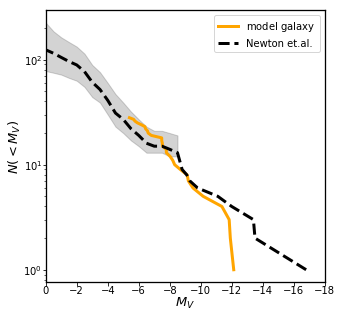

In [9]:
import matplotlib.pyplot as plt
import numpy as np

Lc = np.array([-9.1,-8.8,-13.4,-12,-9.8,-18.1
               -8.8,-16.8,-11.1,-9.3,-13.5])
Lc,cum_Lc = CumArr(Lc)
Lo = np.arange(-8.5,0.5,0.5)
MVs_MW = np.append(Lc,Lo) 

cum_MW = np.array([13,14,15,15,16,19,22,27,31,41,
                   52,61,77,89,96,105,115,124])
cum_MW = np.append(cum_Lc,cum_MW)

cum_MW_l = [12,12,13,13,13,15,17,20,23,30,
            39,44,55,63,67,72,75,78]
cum_MW_h = [19,20,21,21,23,27,32,39,47,
            60,76,89,114,133,147,163,186,225]
MVs=MVs_1
strings = [r'$\mathrm{model\ galaxy}$',r'$z=0.03$']
fig, axs = plt.subplots(figsize=(5,5))
for i in np.arange(len(MVs)):
    arr_uni,cum = CumArr(MVs[i])
    axs.plot(arr_uni,cum,lw=3,label='%s' %strings[i],color='orange')
    
axs.plot(MVs_MW,cum_MW,'--k',label='Newton et.al.',lw=3)
axs.fill_between(Lo, cum_MW_l, cum_MW_h, alpha=0.2,color='#272727')
axs.set_xlim(0,-18)
axs.set_yscale("log")
axs.set_xlabel(r'$M_{V}$',fontsize=13,labelpad=0.01)
axs.set_ylabel(r'$N(<M_{V})$',fontsize=13,labelpad=0.002)
axs.spines['left'].set_linewidth(1.3)
axs.spines['bottom'].set_linewidth(1.3)
axs.spines['top'].set_linewidth(1.3)
axs.spines['right'].set_linewidth(1.3)
axs.tick_params(labelsize=10,pad=0.1,labelrotation=0)
axs.legend()

#plt.savefig('/home/tnguser/code/TheGreatPlane/Vedio_caratio/LF.pdf',bbox_inches='tight',dpi=250)